In [1]:
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bin import utils

In [2]:
gdata = sc.read_h5ad('./RNA/Multitime.filtered.guide.bin20.h5')

In [3]:
gdata = utils.combine_guide_replicates(gdata)

/home/wpy/stereoseq/20240502-SPACseq/bin/utils.py:88: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [4]:
cdf = pd.concat([pd.DataFrame(gdata.X, index=gdata.obs_names, columns=gdata.var_names), gdata.obs], axis=1)

/tmp/ipykernel_34332/1539675293.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = cdf.groupby('marker').sum().sum(axis=1).sort_index()
/tmp/ipykernel_34332/1539675293.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df, palette='rainbow', alpha=0.3)


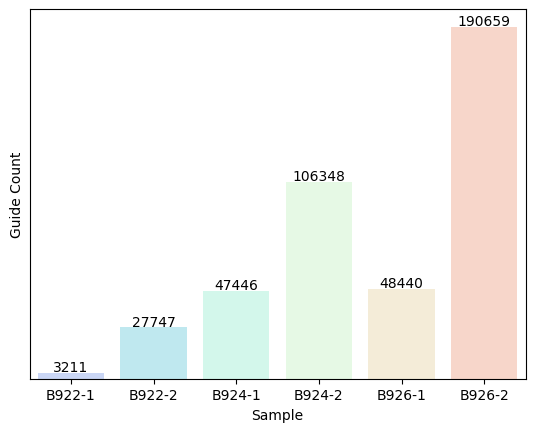

In [5]:
df = cdf.groupby('marker').sum().sum(axis=1).sort_index()
sns.barplot(df, palette='rainbow', alpha=0.3)
plt.ylabel('Guide Count')
plt.xlabel('Sample')
plt.yticks([])
for marker in df.index:
    plt.text(marker, df[marker] + 1000, df[marker], ha='center')
plt.show()

# Down Sample B926-2

190659 -> 75516


100%|██████████| 20/20 [05:16<00:00, 15.81s/it]


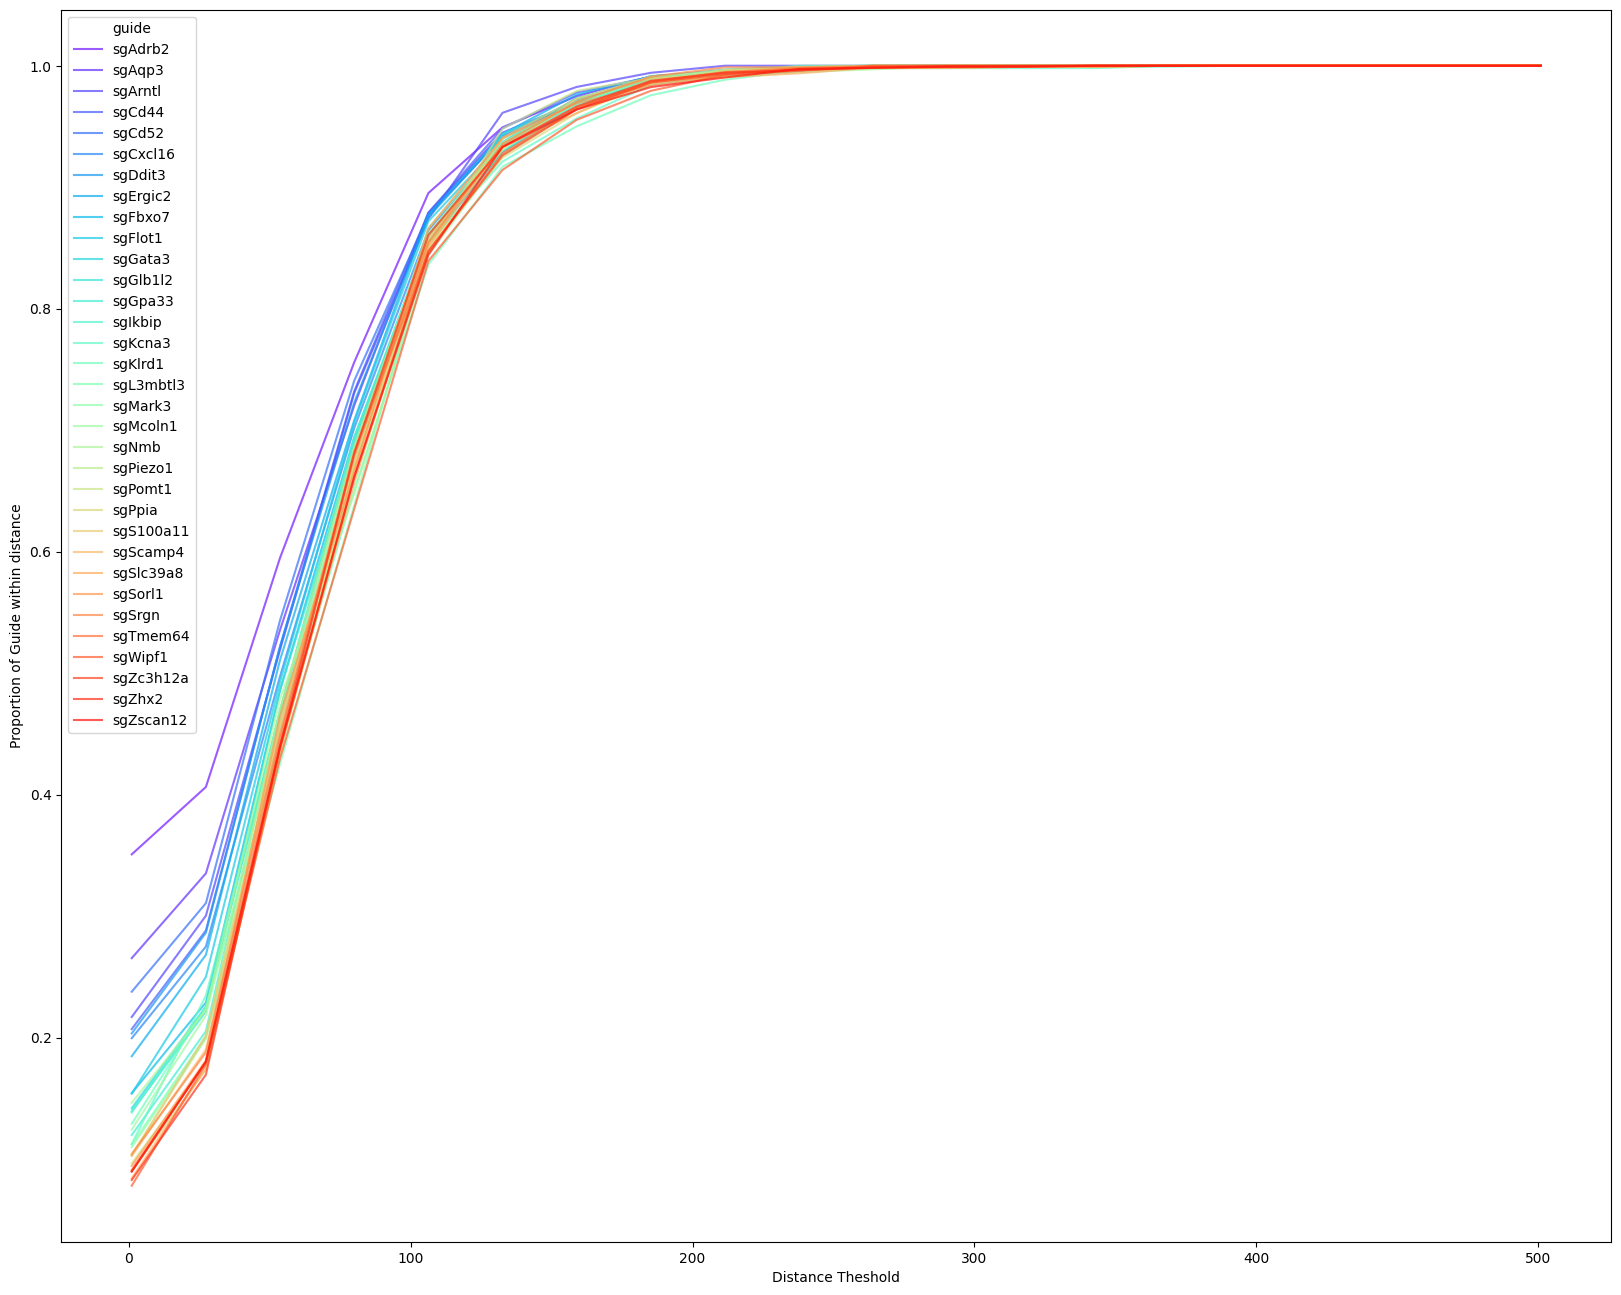

In [6]:
pdata = gdata[gdata.obs.marker == 'B926-2'].copy()
print(pdata.X.sum(), end=' -> ')
ds_size = 100000
ds_bins = np.random.choice(pdata[pdata.X.sum(axis=1) > 0].obs_names, ds_size)
dsdata = pdata.copy()
dsdata[ds_bins].X = 0
print(dsdata.X.sum())

from tqdm import tqdm
from scipy.spatial import distance_matrix

proportion_1 = {}
for threshold in tqdm(np.linspace(1, 501, 20)):
    proportion_1[threshold] = []
    for guide in dsdata.var_names:
        if guide == 'sgnon-targeting': continue
        guide_data = dsdata[dsdata[:, guide].X > 0]
        ntc_data = dsdata[dsdata[:, 'sgnon-targeting'].X > 0]
        in_distance = ((distance_matrix(guide_data.obsm['spatial'], ntc_data.obsm['spatial']) < threshold).sum(axis=1) > 0).sum()
        proportion_1[threshold].append(in_distance / guide_data.shape[0])

d_df = pd.DataFrame(proportion_1).melt()
d_df.index = dsdata[:, dsdata.var_names != 'sgnon-targeting'].var_names.tolist() * 20
d_df.reset_index(inplace=True)
plt.figure(figsize=(20, 16))
sns.lineplot(d_df, x='variable', y='value', hue='index', palette='rainbow', alpha=0.7)
plt.xlabel('Distance Theshold')
plt.ylabel('Proportion of Guide within distance')
plt.legend(title='guide')

/tmp/ipykernel_34332/2740385009.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ln_df, y='ln_dist', x='gene', ax=ax, palette='rainbow', orient='v', alpha=0.6)


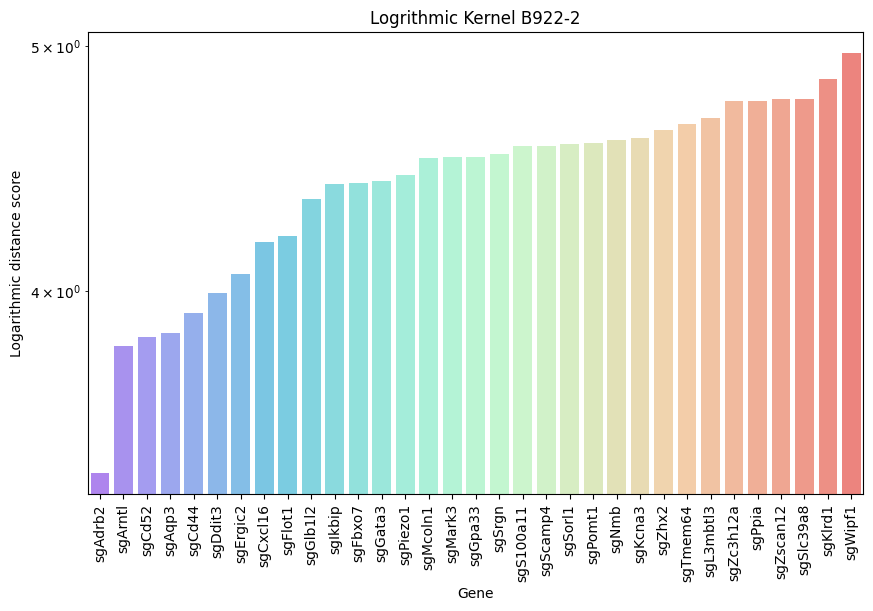

In [12]:
d_df = pd.DataFrame(proportion_1, index=gdata[:, gdata.var_names != 'sgnon-targeting'].var_names.tolist())
#d_df = pd.concat([d_df, pd.DataFrame(proportion_rand, index=['Random_20', '_', '_', '_', 'Random_10000']).iloc[[0, 4], :]], axis=0)

ln_scoring = np.array([np.log(x) for x in np.linspace(1, 100, 20)])

ln_sc = d_df.apply(lambda x: np.multiply(ln_scoring, 1-x), axis=1).sum(axis=1).sort_values()
ln_df = pd.DataFrame(ln_sc, columns=['ln_dist'])
ln_df['gene'] = ln_df.index.str.split('_').str.get(0).tolist()
ln_df.reset_index(inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(ln_df, y='ln_dist', x='gene', ax=ax, palette='rainbow', orient='v', alpha=0.6)
plt.xticks(rotation=90)
# plt.ylim(0,)
plt.gca().set_yscale('log')
plt.xlabel('Gene')
plt.ylabel('Logarithmic distance score')
plt.title('Logrithmic Kernel ' + 'B922-2')
plt.show()

190659 -> 29430


100%|██████████| 20/20 [00:54<00:00,  2.71s/it]


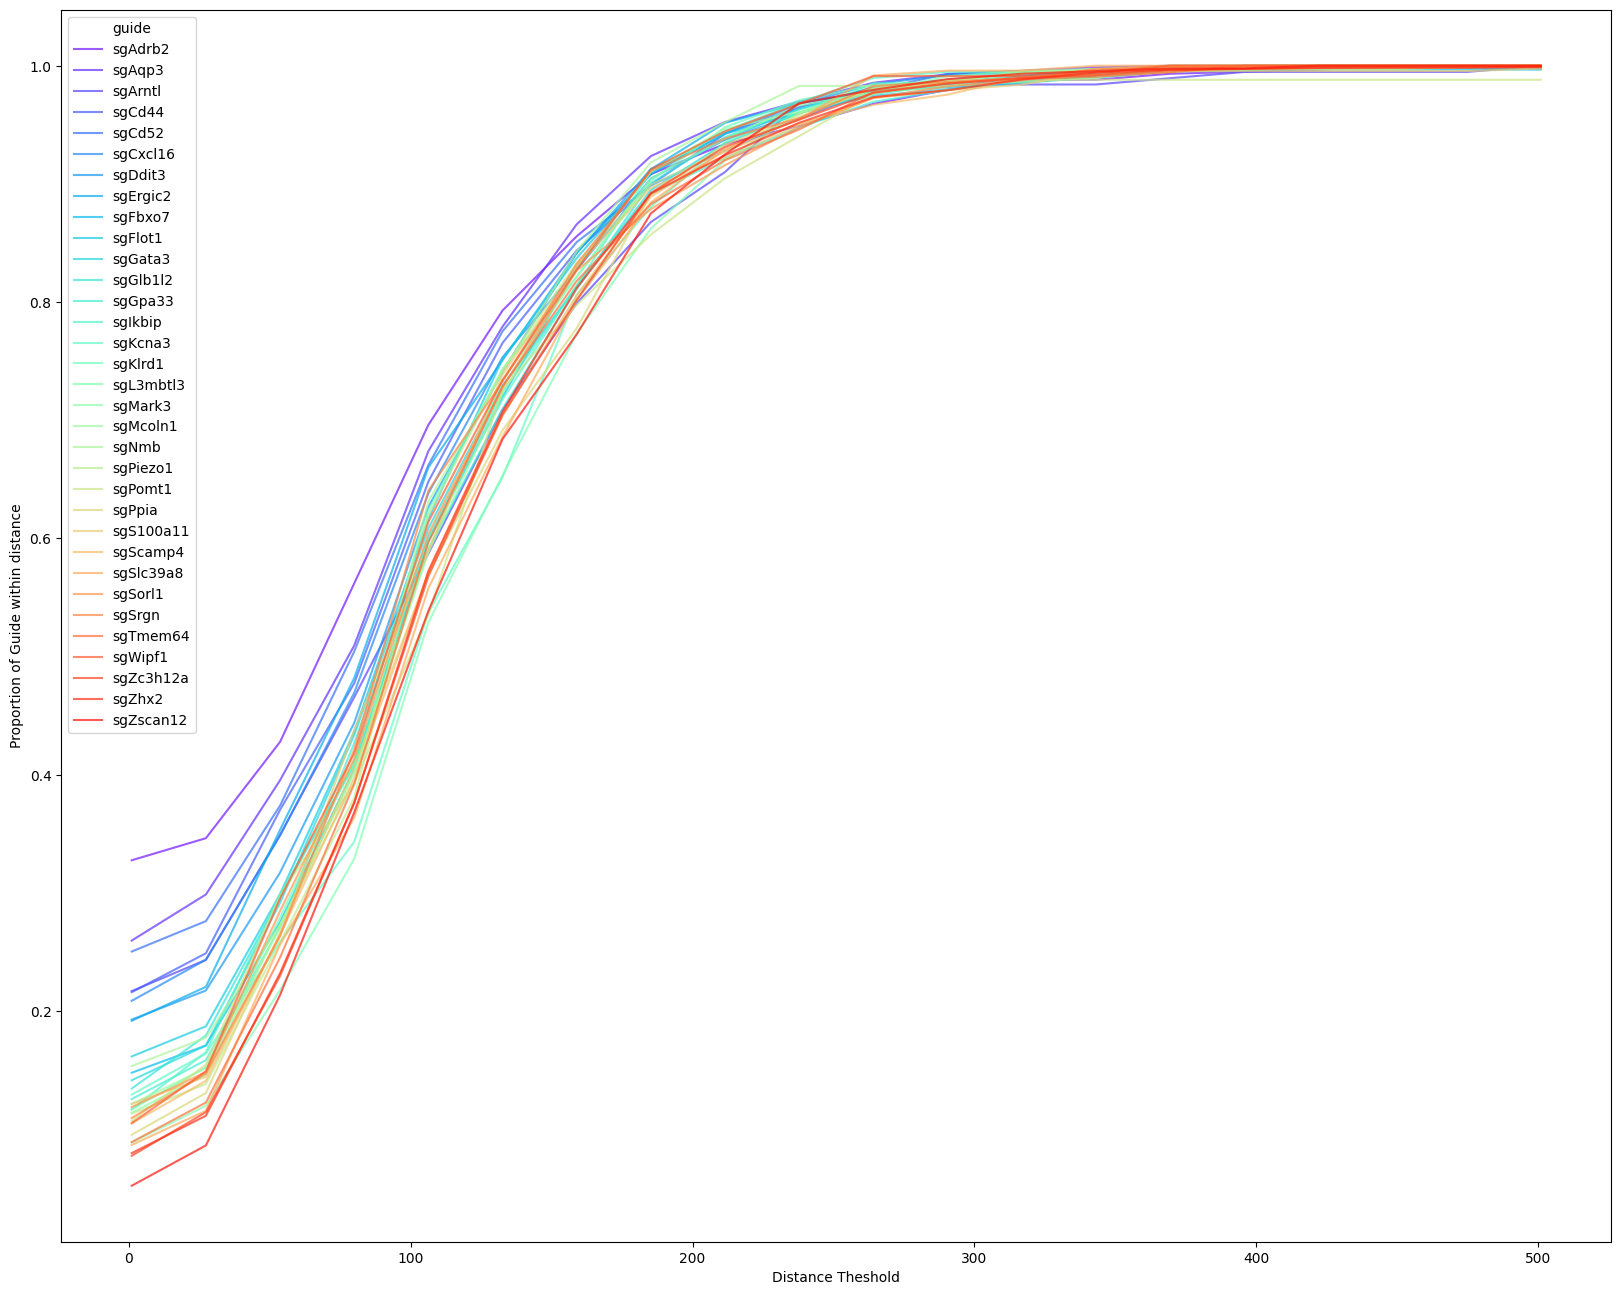

In [7]:
pdata = gdata[gdata.obs.marker == 'B926-2'].copy()
print(pdata.X.sum(), end=' -> ')
ds_size = 200000
ds_bins = np.random.choice(pdata[pdata.X.sum(axis=1) > 0].obs_names, ds_size)
dsdata = pdata.copy()
dsdata[ds_bins].X = 0
print(dsdata.X.sum())

from tqdm import tqdm
from scipy.spatial import distance_matrix

proportion_2 = {}
for threshold in tqdm(np.linspace(1, 501, 20)):
    proportion_2[threshold] = []
    for guide in dsdata.var_names:
        if guide == 'sgnon-targeting': continue
        guide_data = dsdata[dsdata[:, guide].X > 0]
        ntc_data = dsdata[dsdata[:, 'sgnon-targeting'].X > 0]
        in_distance = ((distance_matrix(guide_data.obsm['spatial'], ntc_data.obsm['spatial']) < threshold).sum(axis=1) > 0).sum()
        proportion_2[threshold].append(in_distance / guide_data.shape[0])

d_df = pd.DataFrame(proportion_2).melt()
d_df.index = dsdata[:, dsdata.var_names != 'sgnon-targeting'].var_names.tolist() * 20
d_df.reset_index(inplace=True)
plt.figure(figsize=(20, 16))
sns.lineplot(d_df, x='variable', y='value', hue='index', palette='rainbow', alpha=0.7)
plt.xlabel('Distance Theshold')
plt.ylabel('Proportion of Guide within distance')
plt.legend(title='guide')

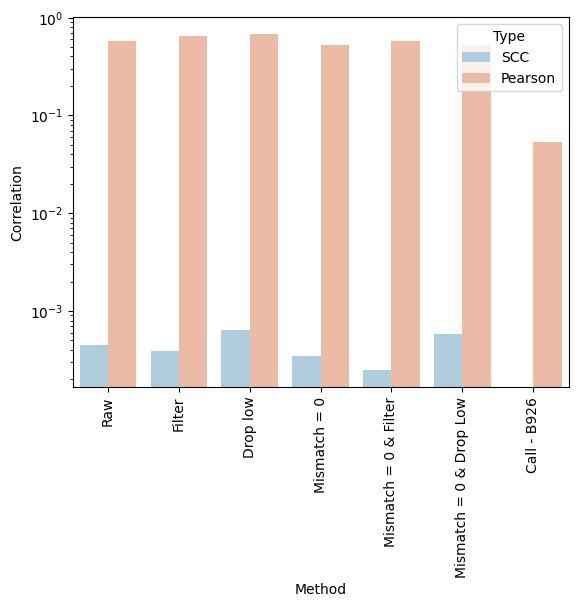

In [41]:
pdf = pd.DataFrame({
    'Method': ['Raw', 'Filter', 'Drop low', 'Mismatch = 0', 'Mismatch = 0 & Filter', 'Mismatch = 0 & Drop Low'] * 2 + ['Call - B926'],
    'Type': ['SCC'] * 6 + ['Pearson'] * 6 + ['Pearson'],
    'Correlation': [0.00045, 0.00039, 0.00064, 0.00035, 0.00025, 0.00058, 0.58,  0.64, 0.68, 0.53, 0.57, 0.53, 0.053]
})
sns.barplot(pdf, x='Method', hue='Type', y='Correlation', palette='RdBu_r')
plt.xticks(rotation=90)
plt.gca().set_yscale('log')

/tmp/ipykernel_34332/2205471120.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ln_df, y='ln_dist', x='gene', ax=ax, palette='rainbow', orient='v', alpha=0.6)


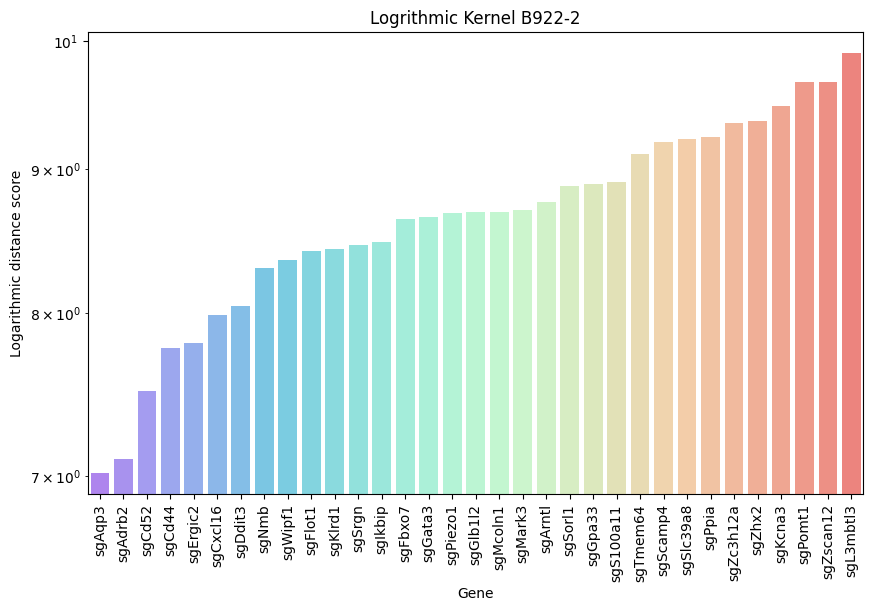

In [13]:
d_df = pd.DataFrame(proportion_2, index=gdata[:, gdata.var_names != 'sgnon-targeting'].var_names.tolist())
#d_df = pd.concat([d_df, pd.DataFrame(proportion_rand, index=['Random_20', '_', '_', '_', 'Random_10000']).iloc[[0, 4], :]], axis=0)

ln_scoring = np.array([np.log(x) for x in np.linspace(1, 100, 20)])

ln_sc = d_df.apply(lambda x: np.multiply(ln_scoring, 1-x), axis=1).sum(axis=1).sort_values()
ln_df = pd.DataFrame(ln_sc, columns=['ln_dist'])
ln_df['gene'] = ln_df.index.str.split('_').str.get(0).tolist()
ln_df.reset_index(inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(ln_df, y='ln_dist', x='gene', ax=ax, palette='rainbow', orient='v', alpha=0.6)
plt.xticks(rotation=90)
# plt.ylim(0,)
plt.gca().set_yscale('log')
plt.xlabel('Gene')
plt.ylabel('Logarithmic distance score')
plt.title('Logrithmic Kernel ' + 'B922-2')
plt.show()

190659 -> 11771


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


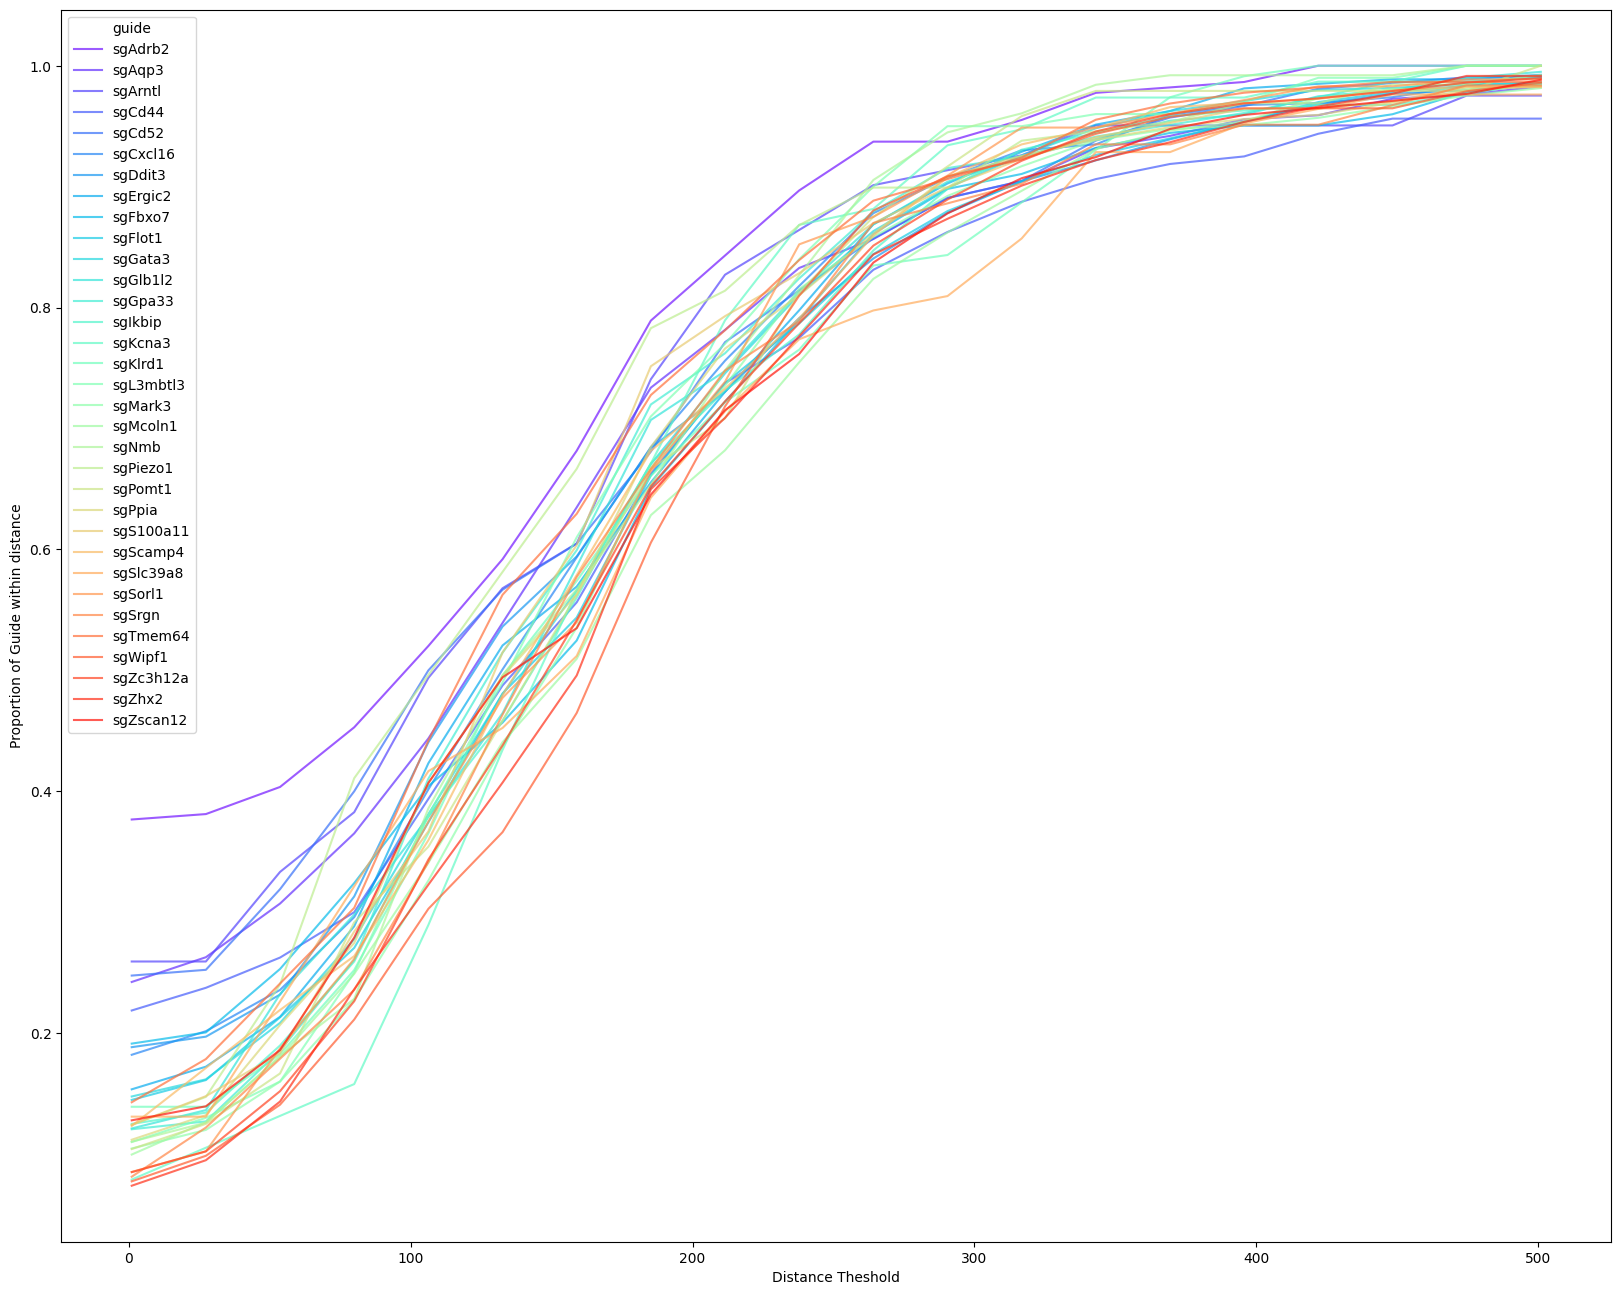

In [8]:
pdata = gdata[gdata.obs.marker == 'B926-2'].copy()
print(pdata.X.sum(), end=' -> ')
ds_size = 300000
ds_bins = np.random.choice(pdata[pdata.X.sum(axis=1) > 0].obs_names, ds_size)
dsdata = pdata.copy()
dsdata[ds_bins].X = 0
print(dsdata.X.sum())

from tqdm import tqdm
from scipy.spatial import distance_matrix

proportion_3 = {}
for threshold in tqdm(np.linspace(1, 501, 20)):
    proportion_3[threshold] = []
    for guide in dsdata.var_names:
        if guide == 'sgnon-targeting': continue
        guide_data = dsdata[dsdata[:, guide].X > 0]
        ntc_data = dsdata[dsdata[:, 'sgnon-targeting'].X > 0]
        in_distance = ((distance_matrix(guide_data.obsm['spatial'], ntc_data.obsm['spatial']) < threshold).sum(axis=1) > 0).sum()
        proportion_3[threshold].append(in_distance / guide_data.shape[0])

d_df = pd.DataFrame(proportion_3).melt()
d_df.index = dsdata[:, dsdata.var_names != 'sgnon-targeting'].var_names.tolist() * 20
d_df.reset_index(inplace=True)
plt.figure(figsize=(20, 16))
sns.lineplot(d_df, x='variable', y='value', hue='index', palette='rainbow', alpha=0.7)
plt.xlabel('Distance Theshold')
plt.ylabel('Proportion of Guide within distance')
plt.legend(title='guide')

/tmp/ipykernel_34332/3390893143.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ln_df, y='ln_dist', x='gene', ax=ax, palette='rainbow', orient='v', alpha=0.6)


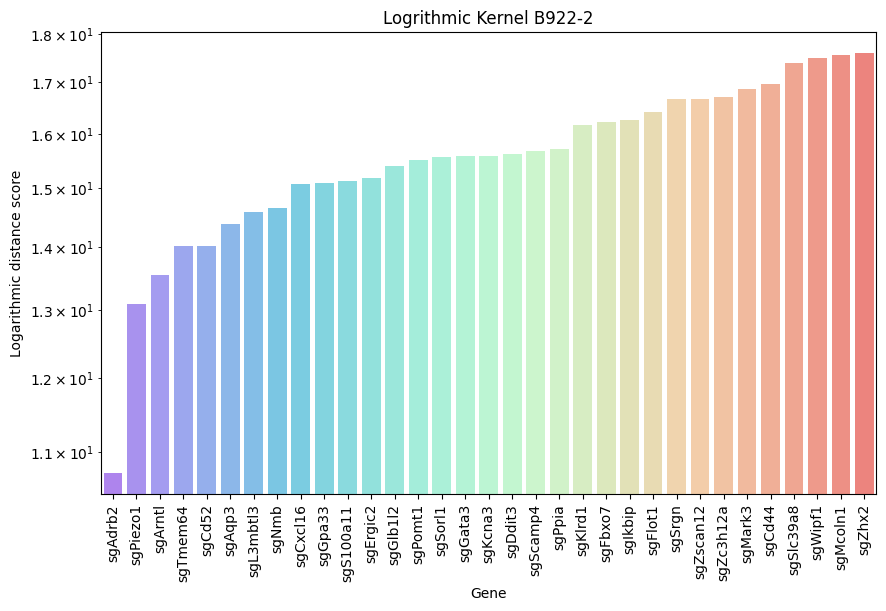

In [14]:
d_df = pd.DataFrame(proportion_3, index=gdata[:, gdata.var_names != 'sgnon-targeting'].var_names.tolist())
#d_df = pd.concat([d_df, pd.DataFrame(proportion_rand, index=['Random_20', '_', '_', '_', 'Random_10000']).iloc[[0, 4], :]], axis=0)

ln_scoring = np.array([np.log(x) for x in np.linspace(1, 100, 20)])

ln_sc = d_df.apply(lambda x: np.multiply(ln_scoring, 1-x), axis=1).sum(axis=1).sort_values()
ln_df = pd.DataFrame(ln_sc, columns=['ln_dist'])
ln_df['gene'] = ln_df.index.str.split('_').str.get(0).tolist()
ln_df.reset_index(inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(ln_df, y='ln_dist', x='gene', ax=ax, palette='rainbow', orient='v', alpha=0.6)
plt.xticks(rotation=90)
# plt.ylim(0,)
plt.gca().set_yscale('log')
plt.xlabel('Gene')
plt.ylabel('Logarithmic distance score')
plt.title('Logrithmic Kernel ' + 'B922-2')
plt.show()

190659 -> 4697


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:11<00:00,  1.67it/s]


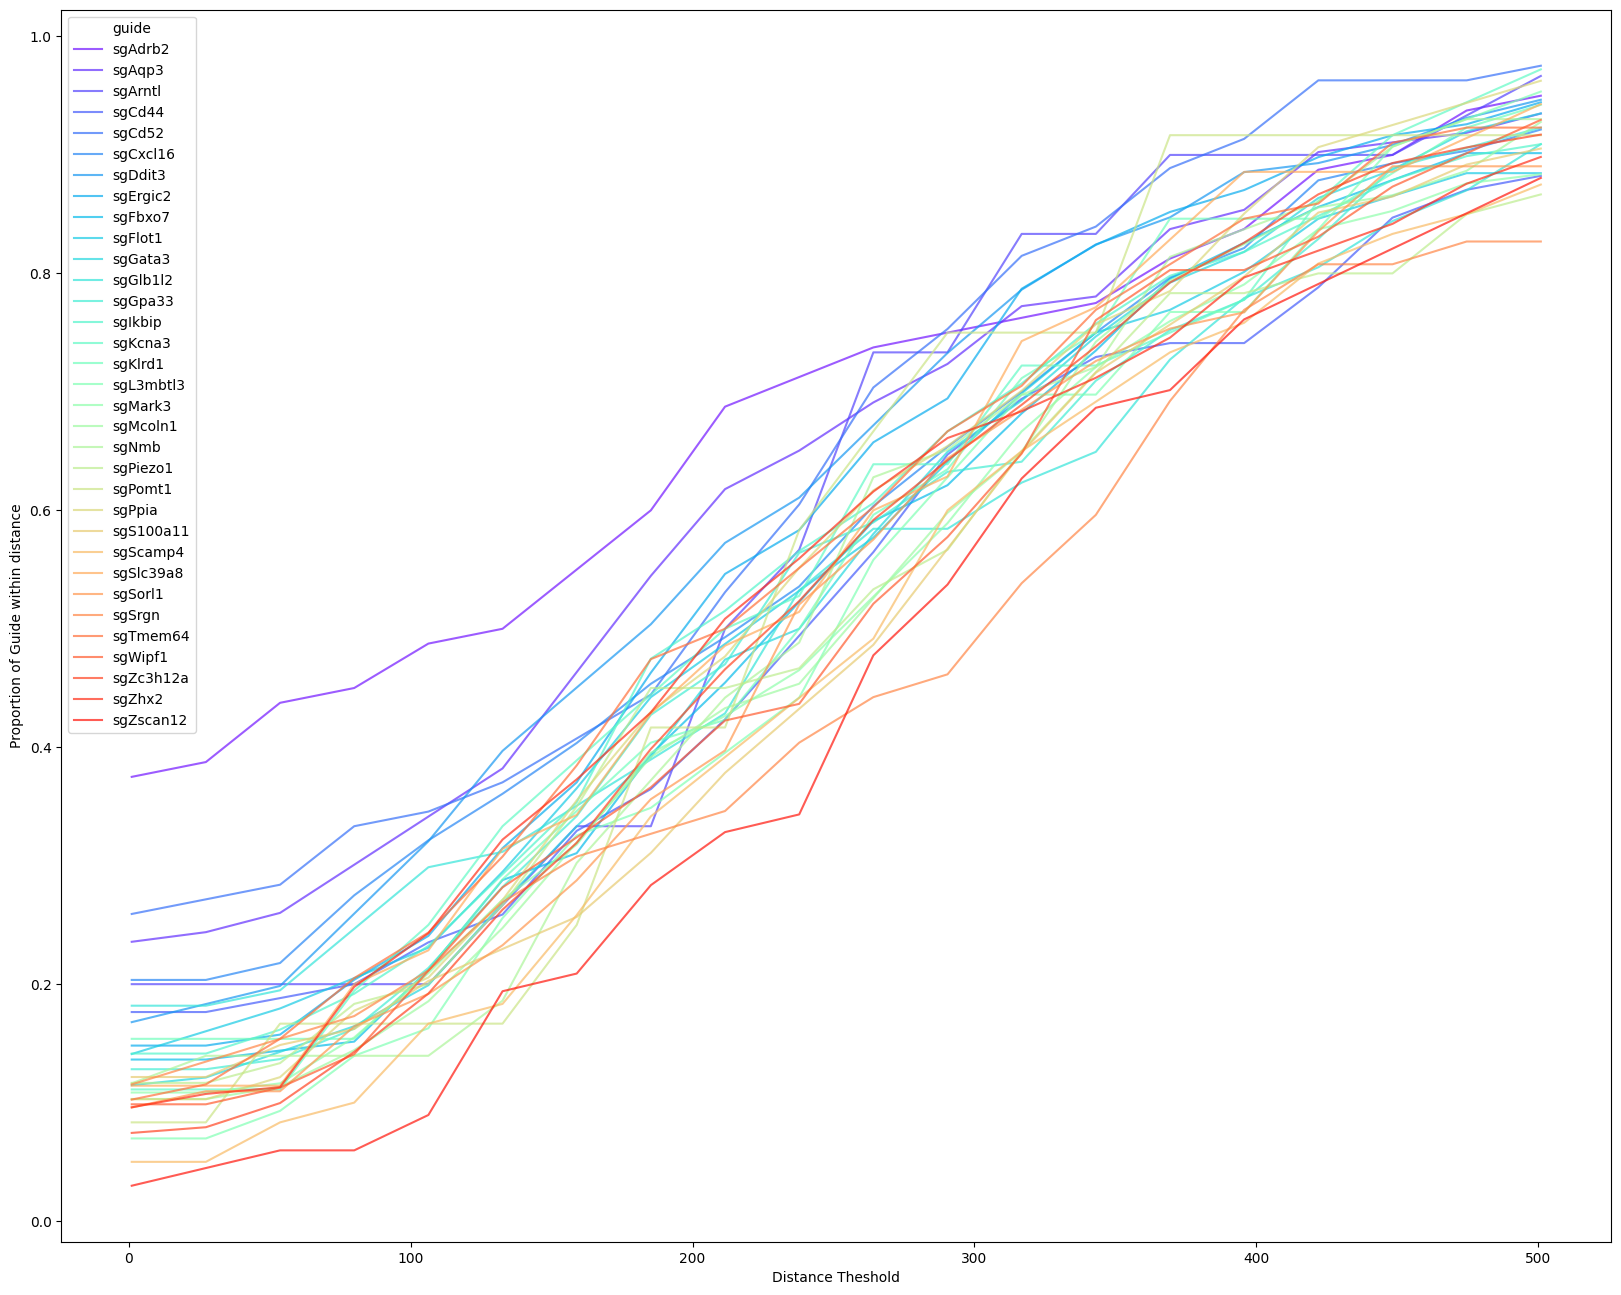

In [9]:
pdata = gdata[gdata.obs.marker == 'B926-2'].copy()
print(pdata.X.sum(), end=' -> ')
ds_size = 400000
ds_bins = np.random.choice(pdata[pdata.X.sum(axis=1) > 0].obs_names, ds_size)
dsdata = pdata.copy()
dsdata[ds_bins].X = 0
print(dsdata.X.sum())

from tqdm import tqdm
from scipy.spatial import distance_matrix

proportion_4 = {}
for threshold in tqdm(np.linspace(1, 501, 20)):
    proportion_4[threshold] = []
    for guide in dsdata.var_names:
        if guide == 'sgnon-targeting': continue
        guide_data = dsdata[dsdata[:, guide].X > 0]
        ntc_data = dsdata[dsdata[:, 'sgnon-targeting'].X > 0]
        in_distance = ((distance_matrix(guide_data.obsm['spatial'], ntc_data.obsm['spatial']) < threshold).sum(axis=1) > 0).sum()
        proportion_4[threshold].append(in_distance / guide_data.shape[0])

d_df = pd.DataFrame(proportion_4).melt()
d_df.index = dsdata[:, dsdata.var_names != 'sgnon-targeting'].var_names.tolist() * 20
d_df.reset_index(inplace=True)
plt.figure(figsize=(20, 16))
sns.lineplot(d_df, x='variable', y='value', hue='index', palette='rainbow', alpha=0.7)
plt.xlabel('Distance Theshold')
plt.ylabel('Proportion of Guide within distance')
plt.legend(title='guide')

/tmp/ipykernel_34332/3942239194.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ln_df, y='ln_dist', x='gene', ax=ax, palette='rainbow', orient='v', alpha=0.6)


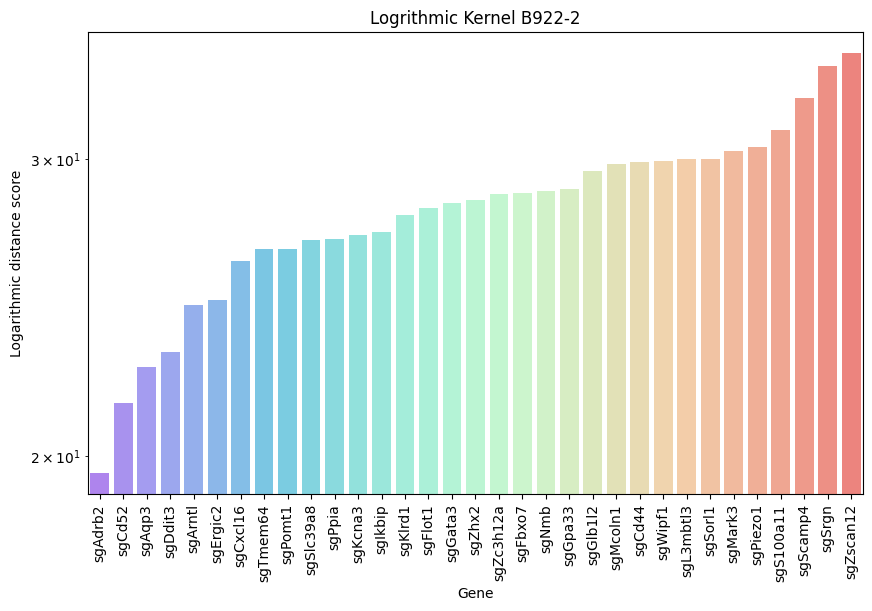

In [16]:
d_df = pd.DataFrame(proportion_4, index=gdata[:, gdata.var_names != 'sgnon-targeting'].var_names.tolist())
#d_df = pd.concat([d_df, pd.DataFrame(proportion_rand, index=['Random_20', '_', '_', '_', 'Random_10000']).iloc[[0, 4], :]], axis=0)

ln_scoring = np.array([np.log(x) for x in np.linspace(1, 100, 20)])

ln_sc = d_df.apply(lambda x: np.multiply(ln_scoring, 1-x), axis=1).sum(axis=1).sort_values()
ln_df = pd.DataFrame(ln_sc, columns=['ln_dist'])
ln_df['gene'] = ln_df.index.str.split('_').str.get(0).tolist()
ln_df.reset_index(inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(ln_df, y='ln_dist', x='gene', ax=ax, palette='rainbow', orient='v', alpha=0.6)
plt.xticks(rotation=90)
# plt.ylim(0,)
plt.gca().set_yscale('log')
plt.xlabel('Gene')
plt.ylabel('Logarithmic distance score')
plt.title('Logrithmic Kernel ' + 'B922-2')
plt.show()

190659 -> 1748


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


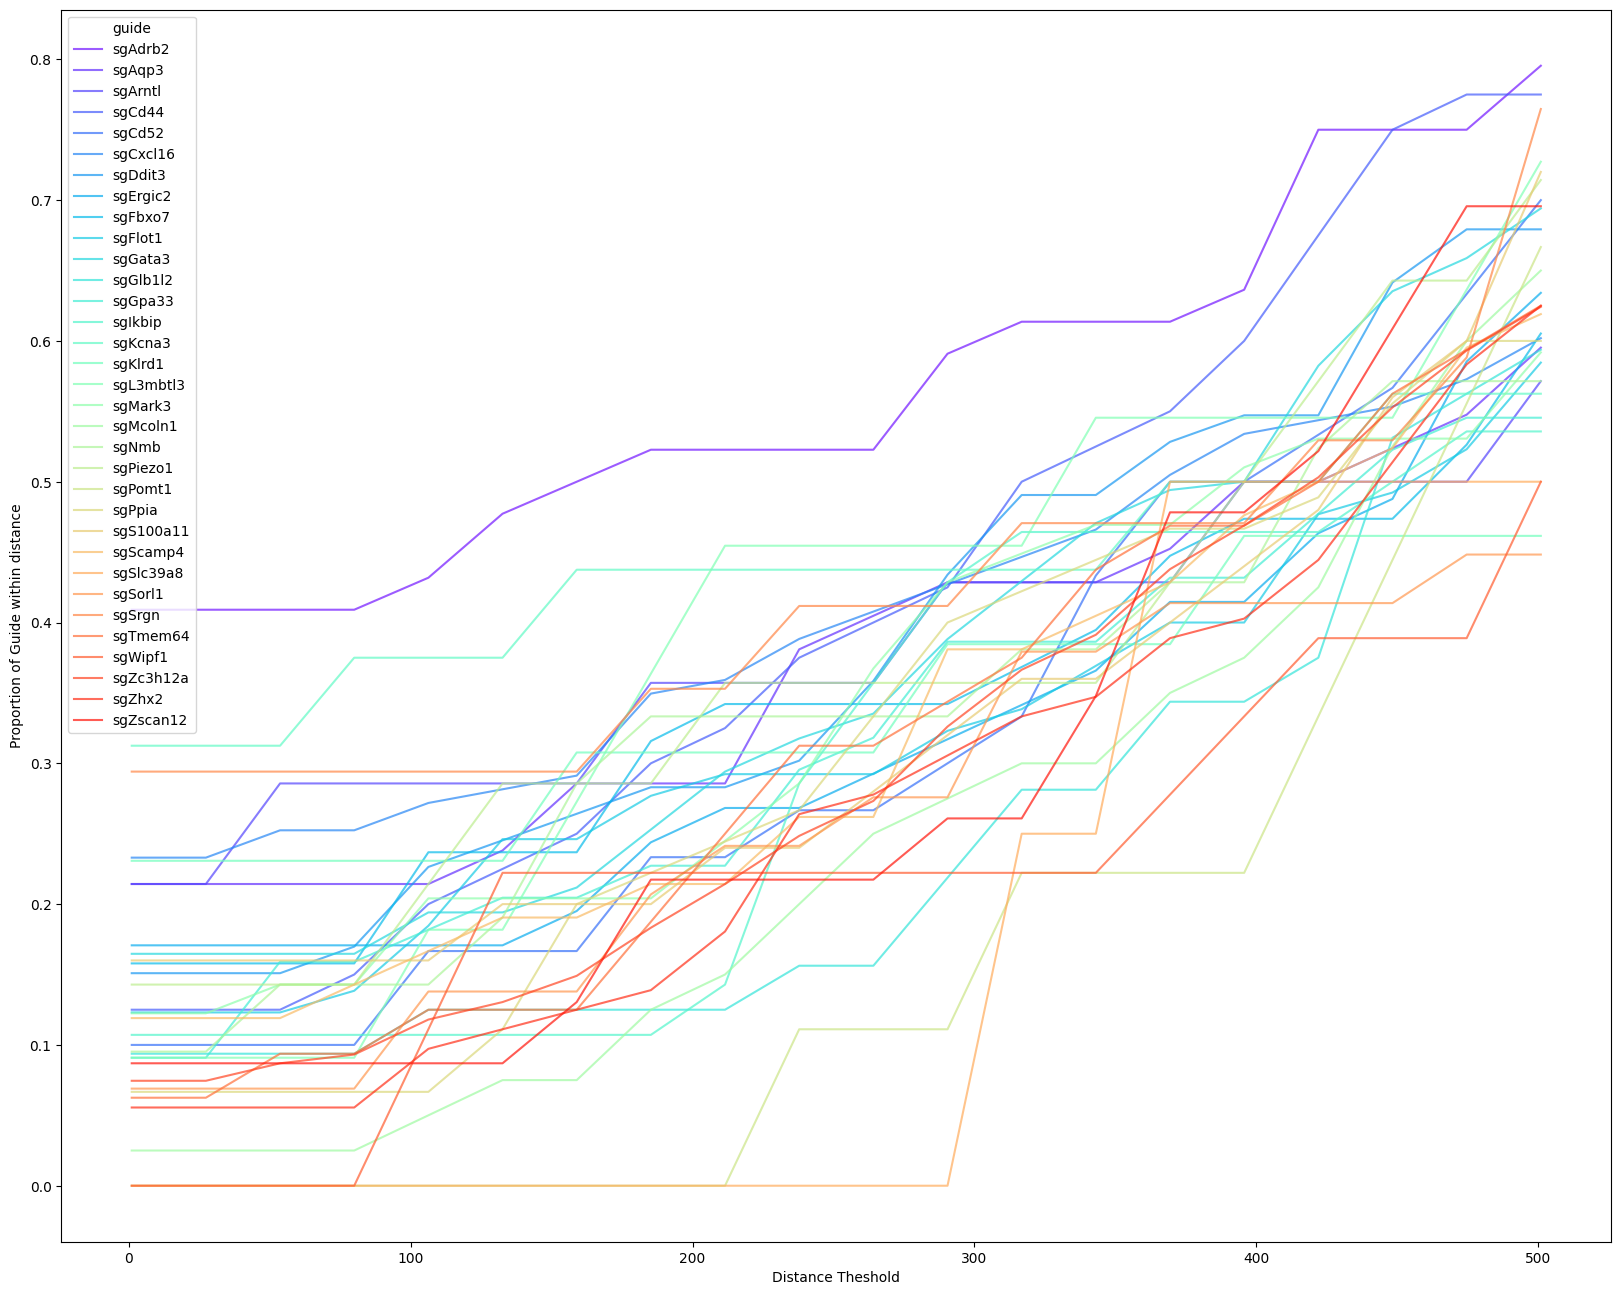

In [10]:
pdata = gdata[gdata.obs.marker == 'B926-2'].copy()
print(pdata.X.sum(), end=' -> ')
ds_size = 500000
ds_bins = np.random.choice(pdata[pdata.X.sum(axis=1) > 0].obs_names, ds_size)
dsdata = pdata.copy()
dsdata[ds_bins].X = 0
print(dsdata.X.sum())

from tqdm import tqdm
from scipy.spatial import distance_matrix

proportion_5 = {}
for threshold in tqdm(np.linspace(1, 501, 20)):
    proportion_5[threshold] = []
    for guide in dsdata.var_names:
        if guide == 'sgnon-targeting': continue
        guide_data = dsdata[dsdata[:, guide].X > 0]
        ntc_data = dsdata[dsdata[:, 'sgnon-targeting'].X > 0]
        in_distance = ((distance_matrix(guide_data.obsm['spatial'], ntc_data.obsm['spatial']) < threshold).sum(axis=1) > 0).sum()
        proportion_5[threshold].append(in_distance / guide_data.shape[0])

d_df = pd.DataFrame(proportion_5).melt()
d_df.index = dsdata[:, dsdata.var_names != 'sgnon-targeting'].var_names.tolist() * 20
d_df.reset_index(inplace=True)
plt.figure(figsize=(20, 16))
sns.lineplot(d_df, x='variable', y='value', hue='index', palette='rainbow', alpha=0.7)
plt.xlabel('Distance Theshold')
plt.ylabel('Proportion of Guide within distance')
plt.legend(title='guide')

/tmp/ipykernel_34332/3440522152.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ln_df, y='ln_dist', x='gene', ax=ax, palette='rainbow', orient='v', alpha=0.6)


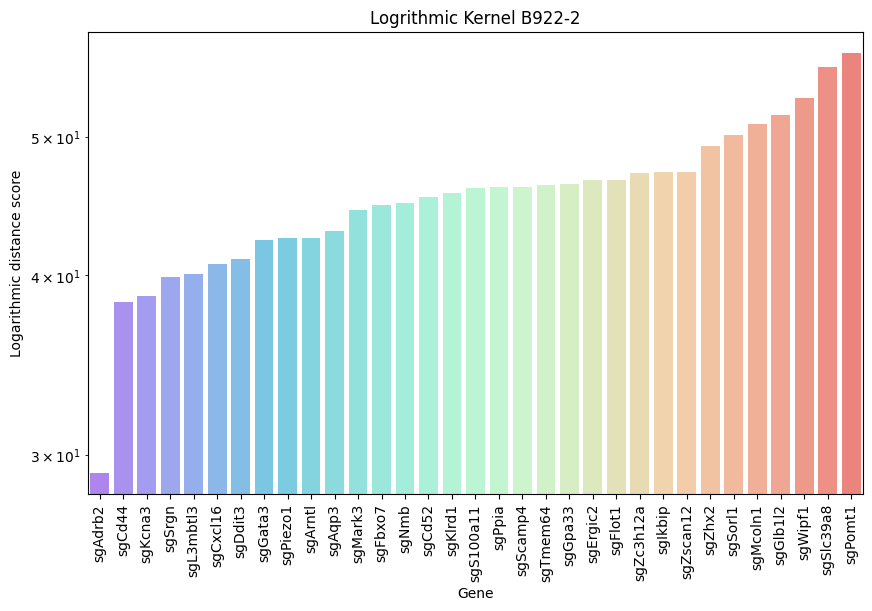

In [17]:
d_df = pd.DataFrame(proportion_5, index=gdata[:, gdata.var_names != 'sgnon-targeting'].var_names.tolist())
#d_df = pd.concat([d_df, pd.DataFrame(proportion_rand, index=['Random_20', '_', '_', '_', 'Random_10000']).iloc[[0, 4], :]], axis=0)

ln_scoring = np.array([np.log(x) for x in np.linspace(1, 100, 20)])

ln_sc = d_df.apply(lambda x: np.multiply(ln_scoring, 1-x), axis=1).sum(axis=1).sort_values()
ln_df = pd.DataFrame(ln_sc, columns=['ln_dist'])
ln_df['gene'] = ln_df.index.str.split('_').str.get(0).tolist()
ln_df.reset_index(inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(ln_df, y='ln_dist', x='gene', ax=ax, palette='rainbow', orient='v', alpha=0.6)
plt.xticks(rotation=90)
# plt.ylim(0,)
plt.gca().set_yscale('log')
plt.xlabel('Gene')
plt.ylabel('Logarithmic distance score')
plt.title('Logrithmic Kernel ' + 'B922-2')
plt.show()

/tmp/ipykernel_34332/3672247672.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(d_df, y='Permutation', x='Correlation', orient='h', palette='Blues')


Text(0.5, 1.0, 'Rank Correlation with Control B926-2')

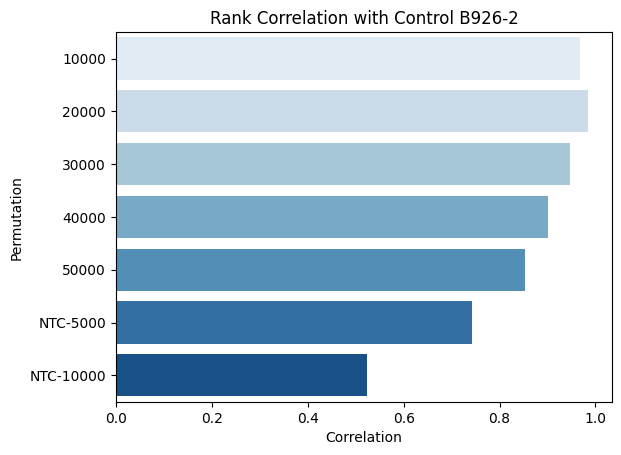

In [33]:
# Rank correlation
d_df = pd.DataFrame({
    'Permutation': ['10000', '20000', '30000', '40000', '50000', 'NTC-5000', 'NTC-10000'],
    'Correlation': [0.967, 0.985, 0.946, 0.901, 0.854, 0.742, 0.523]
})
sns.barplot(d_df, y='Permutation', x='Correlation', orient='h', palette='Blues')
plt.title('Rank Correlation with Control B926-2')